In [324]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

In [3]:
ds = xr.open_dataset("ERA5_califonria_test.grib", engine = "cfgrib")   ###YOUR DATA HERE

In [4]:
ds #overview of grib file

<xarray.Dataset>
Dimensions:     (latitude: 97, longitude: 111, step: 24, time: 245)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-08-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     int64 ...
  * latitude    (latitude) float64 42.09 41.99 41.89 41.79 ... 32.69 32.59 32.49
  * longitude   (longitude) float64 -125.2 -125.1 -125.0 ... -114.3 -114.2
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    d2m         (time, step, latitude, longitude) float32 ...
    t2m         (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-11-14T19:50:36 GRIB to CDM+CF via cfgrib-0....

In [15]:
gribs = pygrib.open("ERA5_califonria_test.grib") #open grib filde with pygrib

In [19]:
grbs.seek(0)

In [298]:
grbs.seek(0) #resets message seeks, whatever that means.
grb = grbs[1] #queries first message (idexes start at 1 for grib files)
grb #returns first message, basically first instance of the data

1:2 metre dewpoint temperature:K (instant):regular_ll:surface:level 0:fcst time 24 hrs:from 201912310000

<function matplotlib.pyplot.show(close=None, block=None)>

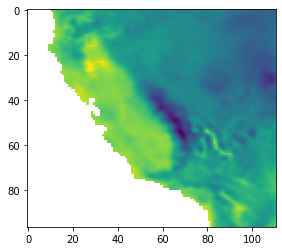

In [299]:
plt.imshow(grb.values) #grb.values returns values for particulat message, here we can preview
plt.show

In [36]:
lats, lons = grb.latlons() #store latitute and longitude as 2-D numpy arrays
grib_value = grb.values #store values as 2-array masked array (check out numpy masked arrays)

In [301]:
comb_array = np.vstack([grib_value.data.ravel(),lats.ravel(), lons.ravel()]).T  #flattens data frame and joins them to creat 3 colums with data
comb_array.shape

(10767, 3)

In [302]:
grib_df = pd.DataFrame(comb_array,columns =["dewpoint temp","LATITUDE","LONGITUDE"])
grib_df = grib_df.replace(9999, np.nan)
grib_df.head()

,dewpoint temp,LATITUDE,LONGITUDE
0,NaN,42.09,-125.17
1,NaN,42.09,-125.07
2,NaN,42.09,-124.97
3,NaN,42.09,-124.87
4,NaN,42.09,-124.77


In [303]:
grib_gdf = gpd.GeoDataFrame(grib_df, geometry=gpd.points_from_xy(grib_df.LONGITUDE, grib_df.LATITUDE), crs = {"init":"EPSG:4326"})
grib_gdf = grib_gdf.to_crs("EPSG:3857")
grib_gdf

/Users/pedrogalarza/miniconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,dewpoint temp,LATITUDE,LONGITUDE,geometry
0,NaN,42.09,-125.17,POINT (-13933860.663 5174470.556)
1,NaN,42.09,-125.07,POINT (-13922728.714 5174470.556)
2,NaN,42.09,-124.97,POINT (-13911596.764 5174470.556)
3,NaN,42.09,-124.87,POINT (-13900464.815 5174470.556)
4,NaN,42.09,-124.77,POINT (-13889332.866 5174470.556)
...,...,...,...,...
10762,274.628174,32.49,-114.57,POINT (-12753874.060 3827804.007)
10763,276.076904,32.49,-114.47,POINT (-12742742.111 3827804.007)
10764,276.545654,32.49,-114.37,POINT (-12731610.162 3827804.007)
10765,276.988037,32.49,-114.27,POINT (-12720478.213 3827804.007)


In [229]:
##user-input:
home_dir = "/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/"
data_dir = os.path.join(home_dir, 'wildfires-1001/data/')

In [304]:
#import california geometries

#State of Califonria
ca_boundary_path = os.path.join(data_dir, 'clean_data/CA_boundary', 'CA_boundary.shp')
CA_boundaries_gdf = gpd.read_file(ca_boundary_path)

#CA grid map
county_grid_path = os.path.join(data_dir, 'clean_data/county_grid/county_grid.shp')
county_grid_gdf = gpd.read_file(county_grid_path)

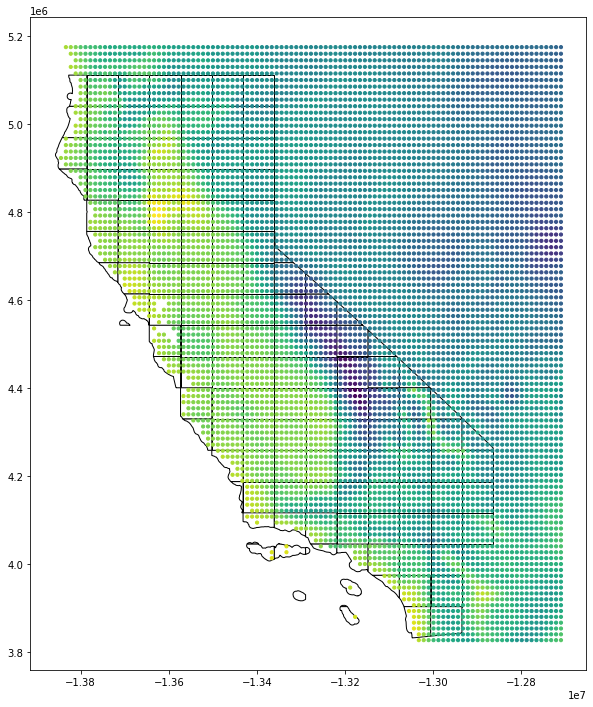

In [305]:
#plot messsege data over grid partition

ax1 =county_grid_gdf.plot(color='white', edgecolor='black',figsize=(12,12))
grib_gdf.plot(ax = ax1,column='dewpoint temp',markersize=10,figsize=(15,15))
plt.show()

In [370]:
from datetime import datetime

message_feautres = str(grb).split(":")
message_date = message_feautres[-1][5:-4]
message_date = message_date[:4]+"-"+message_date[4:6]+"-"+message_date[-2:]
message_hours = str(int(message_feautres[-2][10:-4])%24)

date_time_str = message_date+" "+message_hours
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H')

In [374]:
#groupby grid section adn aggregate data by mean
grib_grid_join = gpd.sjoin(county_grid_gdf, grib_gdf, op = 'contains', how='left').groupby("GRID_ID").aggregate({"dewpoint temp":"mean"})
grib_grid_join.columns=["dewpoint temp grid mean"]

#join aggregated data to origional grid df, add date time
grib_county_join = county_grid_gdf.join(grib_grid_join, on = "GRID_ID")
grib_county_join['date-time'] = date_time_obj 
grib_county_join

,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_ARE,GRID_AREA,GRID_ID,COUNTY_GRI,COUNTY_G_1,geometry,dewpoint temp grid mean,date-time
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,49.0,4.936293e+09,0.427385,"POLYGON ((-13502275.000 4897930.000, -13431275...",272.747008,2019-12-31
1,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,50.0,1.535563e+09,0.365571,"POLYGON ((-13502275.000 4826930.000, -13431275...",276.311516,2019-12-31
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,65.0,2.544187e+09,0.605694,"POLYGON ((-13431275.000 4826930.000, -13360275...",271.235026,2019-12-31
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,39.0,2.029400e+09,0.482585,"POLYGON ((-13573275.000 4684930.000, -13502275...",280.120166,2019-12-31
4,Contra Costa,013,06013,1871930816,209819213,3.351027e+09,5.041000e+09,40.0,1.618024e+09,0.482844,"POLYGON ((-13573275.000 4613930.000, -13502275...",279.491406,2019-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Tulare,107,06107,12495016292,37081410,1.929486e+10,5.041000e+09,98.0,4.535463e+09,0.235061,"POLYGON ((-13289275.000 4400930.000, -13218275...",278.295487,2019-12-31
130,Tehama,103,06103,7639720404,32276063,1.313738e+10,5.041000e+09,25.0,4.171626e+09,0.317539,"POLYGON ((-13644275.000 4897930.000, -13573275...",281.686491,2019-12-31
131,Butte,007,06007,4238423343,105325812,7.340035e+09,5.041000e+09,36.0,2.479630e+09,0.337823,"POLYGON ((-13573275.000 4897930.000, -13502275...",278.680697,2019-12-31
132,Stanislaus,099,06099,3874642752,46376455,6.250517e+09,5.041000e+09,54.0,3.614684e+09,0.578302,"POLYGON ((-13502275.000 4542930.000, -13431275...",279.792836,2019-12-31


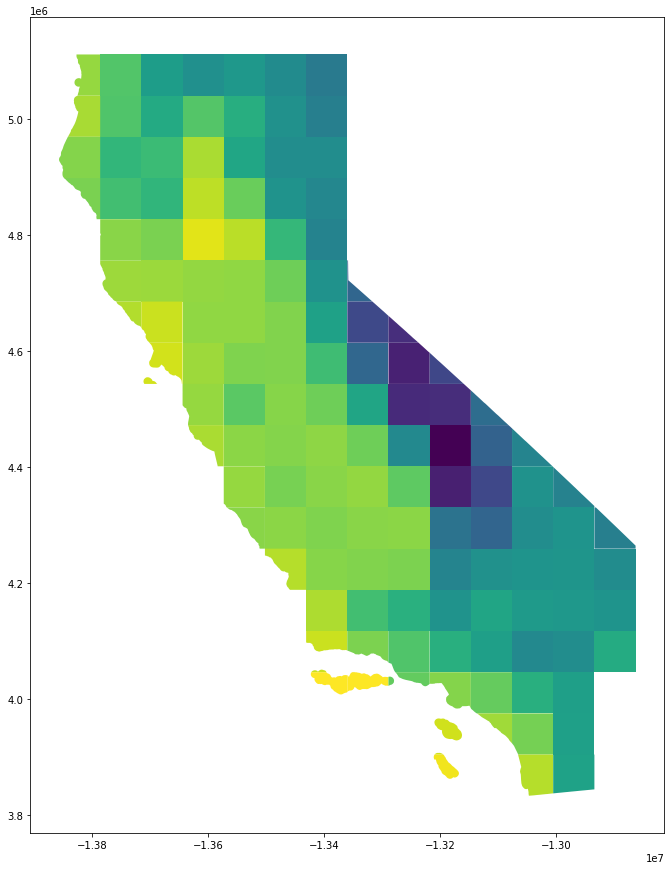

In [375]:
joined_agg.plot(column='dewpoint temp',figsize = (15,15))
plt.show()

In [377]:
#ok now lets start looping though these messages......

grb_list = []
for i in range(1,6):
    grb_list.append(grbs[i]) #queries first message (idexes start at 1 for grib files)
grb_list

[1:2 metre dewpoint temperature:K (instant):regular_ll:surface:level 0:fcst time 24 hrs:from 201912310000,
 2:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 24 hrs:from 201912310000,
 3:2 metre dewpoint temperature:K (instant):regular_ll:surface:level 0:fcst time 1 hrs:from 202001010000,
 4:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 1 hrs:from 202001010000,
 5:2 metre dewpoint temperature:K (instant):regular_ll:surface:level 0:fcst time 2 hrs:from 202001010000]